<div style="background-color: rgb(230, 230, 230);">

---
# T501 - SP23 - Assignment 1
# *Data Analysis with Spark and Scala*
---

<div style="background-color: rgb(230, 230, 230);">

---
## Assignment Details

### Objectives
The learning objectives of this assignment are...
1. to practice using Spark with Scala to query and aggregate data in order to analyze data
2. to gain experience using the CloudXLab and Jupyter notebook interfaces
3. to work successfully in a team on a collaborative assignment

### General Instructions
* **Please do all of these queries using Spark code, and not SparkSQL.**  (The next assignment will allow SparkSQL.) 
* Upload the 5 .CSV files below into your HDFS user directory on Ambari in CloudXLab. The files should all begin with ‘NW_’. (An entity-relationship diagram for the data is provided below and in the notebook.)
* Upload the Jupyter notebook (.ipynb) to your Jupyter Notebook directory on CloudXLab. Enter all of your code and answers into this notebook.
* Note that some code is given to you, but is provided as images. The process of retyping this code will help to familiarize you with the Spark and Scala syntax.
* Your modified Jupyter notebook will serve as your group’s submission for the assignment. You should also submit both an .ipynb and PDF versions of the notebook. PDFs are best generated by printing from CloudXLab to a PDF or your system. (Downloads of PDFs from CloudXLab does not work reliably.)

### Questions to Answer
1.	How many orders were placed by each customer?
2.	How many orders were placed in each country?
3.	How many orders were placed each month? each year?
4.	What is the total sales for each customer by year?
5.	What is the average order total by customer? by customer and then year?
6.	Show the customerID and their most frequently ordered productID. (i.e., the product they ordered the most times, not necessarily in the greatest quantity.) The final output should be the CustomerID for each customer and the number of times they ordered their most frequently ordered product.
    - Hint: Consider CustomerID SAVEA. They ordered productID 2, five different times.  This was the product they ordered most frequently, not necessarily in the highest quantity, but the product that appeared most often on their orders.  
7.	Find the bottom 3 customers who placed the fewest number of orders.  
    - For these customers, output the companyName, contactName, and contactTitle.
8.	If you look in the OrderDetails table, around 38% of all orders received some sort of discount.  Can you detect any patterns of why some orders got a discount, while others received 0 discount?  
    - Please provide your analysis and a summary of what you find.

### Entity-Relationship Diagram for the data files
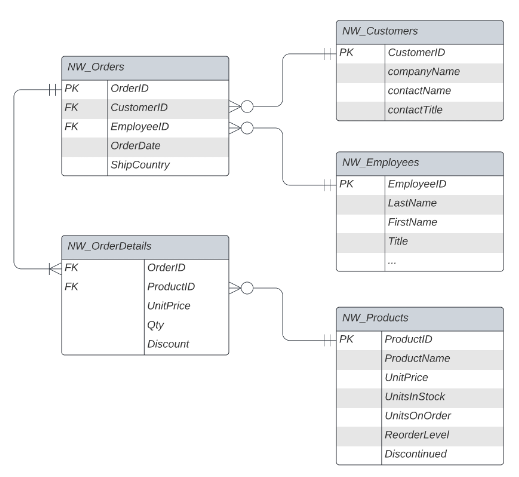
  


## Prep 1 - Set up Spark environment
Execute (run) the code in the following cell to initiate the Spark environment and load required libraries.

In [1]:
import org.apache.spark.sql.SparkSession
import org.apache.log4j.{Level, Logger}
import org.apache.spark.sql.functions.{to_date,month,year}

## Prep 2 - Read Data
Read each table (.csv file) into a Spark dataFrame.
* Order Details
* Orders
* Employees
* Products
* Customers

The code for the first one is provided below. You will need to retype it in the code cell below.

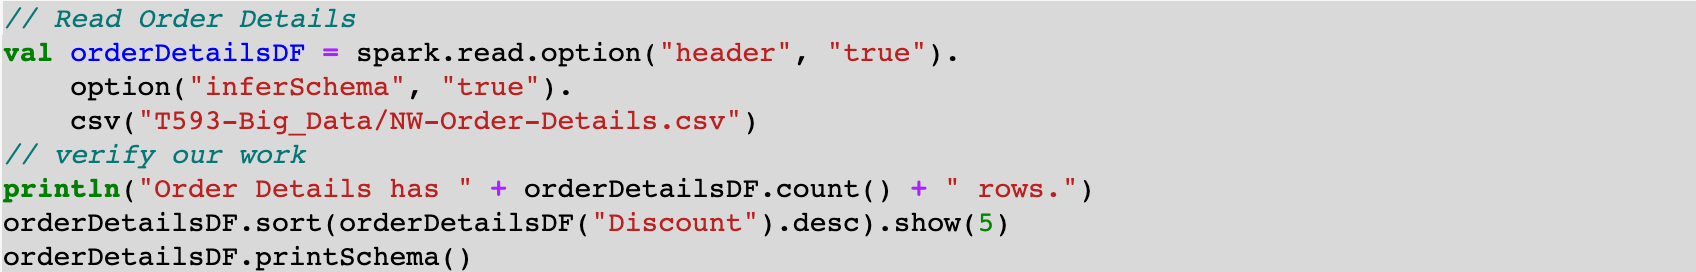

(**NOTE:** This code assumes that the files are in a directory called 'T593-Big_Data/' on the CloudXLab HDFS file system. If your files are in a different directory or are in your home directory, modify or remove that directory name.)



In [2]:
// Read and verify Order Details

val orderDetailsDF = spark.read.option("header", "true").
    option("inferSchema", "true").
    csv("HW 1/NW-Order-Details.csv")

println("Order Details has " + orderDetailsDF.count() + "rows.")
orderDetailsDF.sort(orderDetailsDF("Discount").desc).show(5)
orderDetailsDF.printSchema()

Order Details has 2155rows.
+-------+---------+---------+---+--------+
|OrderID|ProductId|UnitPrice|Qty|Discount|
+-------+---------+---------+---+--------+
|  10260|       62|     39.4| 15|    0.25|
|  10263|       74|      8.0| 36|    0.25|
|  10260|       70|     12.0| 21|    0.25|
|  10260|       41|      7.7| 16|    0.25|
|  10263|       16|     13.9| 60|    0.25|
+-------+---------+---------+---+--------+
only showing top 5 rows

root
 |-- OrderID: integer (nullable = true)
 |-- ProductId: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Qty: integer (nullable = true)
 |-- Discount: double (nullable = true)



orderDetailsDF = [OrderID: int, ProductId: int ... 3 more fields]


[OrderID: int, ProductId: int ... 3 more fields]

In [4]:
// Read and verify Orders

val ordersDF = spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("HW 1/NW-Orders.csv")

println("Orders has " + ordersDF.count() + " rows.")
ordersDF.sort(ordersDF("OrderDate").desc).show(5)
ordersDF.printSchema()


Orders has 830 rows.
+-------+----------+----------+--------------------+-----------+
|OrderID|CustomerID|EmployeeID|           OrderDate|ShipCountry|
+-------+----------+----------+--------------------+-----------+
|  11075|     RICSU|         8|1998-05-04 00:00:...|Switzerland|
|  11077|     RATTC|         1|1998-05-04 00:00:...|        USA|
|  11074|     SIMOB|         7|1998-05-04 00:00:...|    Denmark|
|  11076|     BONAP|         4|1998-05-04 00:00:...|     France|
|  11071|     LILAS|         1|1998-05-03 00:00:...|  Venezuela|
+-------+----------+----------+--------------------+-----------+
only showing top 5 rows

root
 |-- OrderID: integer (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- EmployeeID: integer (nullable = true)
 |-- OrderDate: timestamp (nullable = true)
 |-- ShipCountry: string (nullable = true)



ordersDF = [OrderID: int, CustomerID: string ... 3 more fields]


[OrderID: int, CustomerID: string ... 3 more fields]

In [5]:
// Read and verify Employees

val employeesDF = spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("HW 1/NW-Employees.csv")

println("Employees has " + employeesDF.count() + " rows.")
employeesDF.sort(employeesDF("LastName").asc).show(5)
employeesDF.printSchema()


Employees has 9 rows.
+----------+---------+---------+--------------------+---------+--------+-------+-----+-------+-------+---------+
|EmployeeID| LastName|FirstName|               Title|BirthDate|HireDate|   City|State|    Zip|Country|ReportsTo|
+----------+---------+---------+--------------------+---------+--------+-------+-----+-------+-------+---------+
|         9| Buchanan|   Steven|Sales Representative|  1/25/66|11/13/94| London| null|WG2 7LT|     UK|        5|
|         8| Callahan|    Laura|Inside Sales Coor...|   1/7/58|  3/3/94|Seattle|   WA|  98105|    USA|        2|
|         2|  Davolio|    Nancy|Vice President, S...|  2/17/52| 8/12/92| Tacoma|   WA|  98401|    USA|        0|
|         5|Dodsworth|     Anne|       Sales Manager|   3/2/55|10/15/93| London| null|SW1 8JR|     UK|        2|
|         1|   Fuller|   Andrew|Sales Representative|  12/6/48| 4/29/92|Seattle|   WA|  98122|    USA|        2|
+----------+---------+---------+--------------------+---------+--------+--

employeesDF = [EmployeeID: int, LastName: string ... 9 more fields]


[EmployeeID: int, LastName: string ... 9 more fields]

In [6]:
// Read and verify Products

val productsDF = spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("HW 1/NW-Products.csv")

println("Products has " + productsDF.count() + " rows.")
productsDF.sort(productsDF("UnitPrice").desc).show(5)
productsDF.printSchema()


Products has 77 rows.
+---------+--------------------+---------+------------+------------+------------+------------+
|ProductID|         ProductName|UnitPrice|UnitsInStock|UnitsOnOrder|ReorderLevel|Discontinued|
+---------+--------------------+---------+------------+------------+------------+------------+
|       38|         C�tedeBlaye|    263.5|          17|           0|          15|           0|
|       29|Th�ringerRostbrat...|   123.79|           0|           0|           0|           1|
|        9|       MishiKobeNiku|     97.0|          29|           0|           0|           1|
|       20| SirRodneysMarmalade|     81.0|          40|           0|           0|           0|
|       18|     CarnarvonTigers|     62.5|          42|           0|           0|           0|
+---------+--------------------+---------+------------+------------+------------+------------+
only showing top 5 rows

root
 |-- ProductID: integer (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Uni

productsDF = [ProductID: int, ProductName: string ... 5 more fields]


[ProductID: int, ProductName: string ... 5 more fields]

In [7]:
// Read and verify Customers

val customersDF = spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("HW 1/NW-Customers.csv")

println("Customers has " + customersDF.count() + " rows.")
customersDF.sort(customersDF("CompanyName").asc).show(5)
customersDF.printSchema()


Customers has 91 rows.
+----------+--------------------+-----------------+--------------------+
|CustomerID|         companyName|      contactName|        contactTitle|
+----------+--------------------+-----------------+--------------------+
|     ALFKI| Alfreds Futterkiste|     Maria Anders|Sales Representative|
|     ANATR|Ana Trujillo Empa...|     Ana Trujillo|               Owner|
|     ANTON|Antonio Moreno Ta...|   Antonio Moreno|               Owner|
|     AROUT|     Around the Horn|     Thomas Hardy|Sales Representative|
|     BSBEV|       B's Beverages|Victoria Ashworth|Sales Representative|
+----------+--------------------+-----------------+--------------------+
only showing top 5 rows

root
 |-- CustomerID: string (nullable = true)
 |-- companyName: string (nullable = true)
 |-- contactName: string (nullable = true)
 |-- contactTitle: string (nullable = true)



customersDF = [CustomerID: string, companyName: string ... 2 more fields]


[CustomerID: string, companyName: string ... 2 more fields]

---
---
# Basic Queries

---
### Q1 - How many orders were placed by each customer?
Here is an answer to get you started. Retype the code in the code cell below.

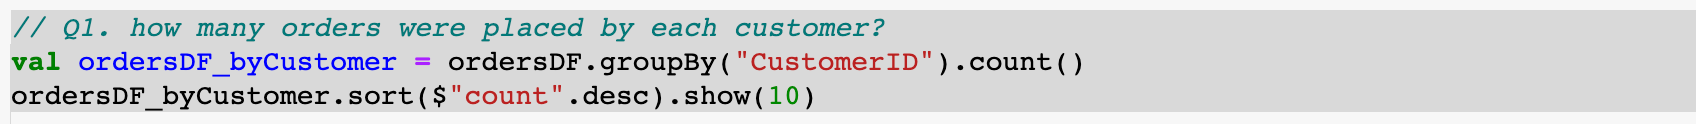

In [8]:
// Q1. how many orders were placed by each customer?
// Retype the code from above and run it.

val ordersDF_byCustomer = ordersDF.groupBy("CustomerID").count()
ordersDF_byCustomer.sort($"count".desc).show(10)


[Stage 31:========================================>             (150 + 6) / 200]+----------+-----+
|CustomerID|count|
+----------+-----+
|     SAVEA|   31|
|     ERNSH|   30|
|     QUICK|   28|
|     HUNGO|   19|
|     FOLKO|   19|
|     RATTC|   18|
|     HILAA|   18|
|     BERGS|   18|
|     BONAP|   17|
|     FRANK|   15|
+----------+-----+
only showing top 10 rows



ordersDF_byCustomer = [CustomerID: string, count: bigint]


[CustomerID: string, count: bigint]

---
### Q2 - How many orders were placed in each country?

In [9]:
// Q2 - How many orders were placed in each country?
// This is very similar to Q1. Write your code below and run it.

val ordersDF_byCountry = ordersDF.groupBy("ShipCountry").count()
ordersDF_byCountry.sort($"count".desc).show(10)


+-----------+-----+
|ShipCountry|count|
+-----------+-----+
|    Germany|  122|
|        USA|  122|
|     Brazil|   82|
|     France|   77|
|         UK|   56|
|  Venezuela|   46|
|    Austria|   40|
|     Sweden|   37|
|     Canada|   30|
|     Mexico|   28|
+-----------+-----+
only showing top 10 rows



ordersDF_byCountry = [ShipCountry: string, count: bigint]


[ShipCountry: string, count: bigint]

---
### Q3 - How many orders were placed per month? per year?
For this question, we will need to add additional columns to the Orders dataframe. The following code walks you through this approach. <u>Retype the provided code in the code cell below.</u> 
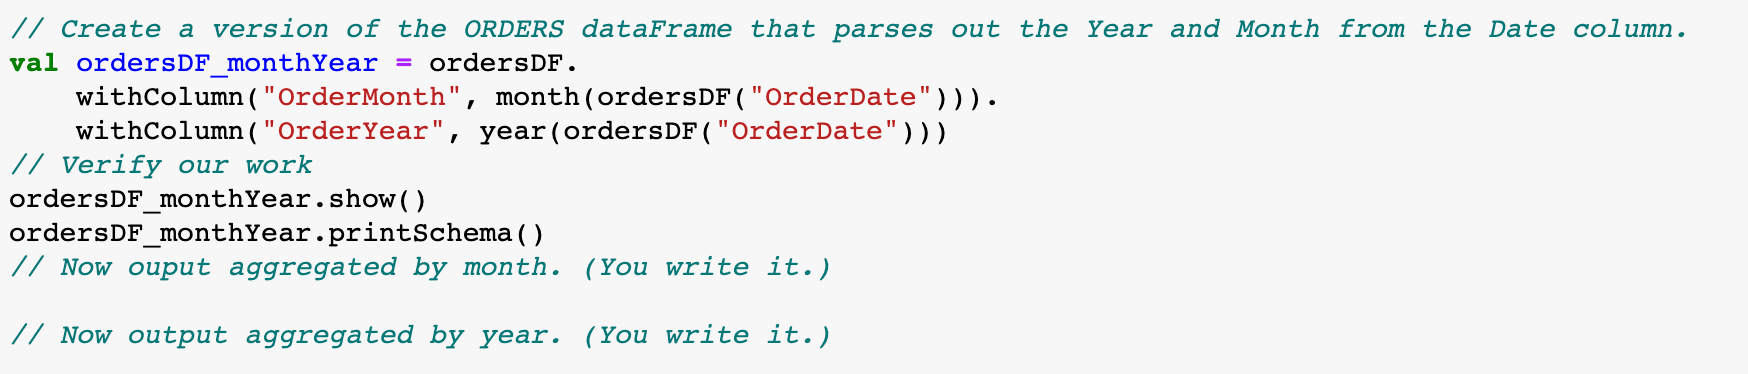

In [10]:
// Q3 - How many orders were placed per month? per year?

val ordersDF_monthYear = ordersDF.
    withColumn ("OrderMonth", month(ordersDF("OrderDate"))).
    withColumn("OrderYear", year(ordersDF("OrderDate")))

ordersDF_monthYear.show()
ordersDF_monthYear.printSchema()


+-------+----------+----------+--------------------+-----------+----------+---------+
|OrderID|CustomerID|EmployeeID|           OrderDate|ShipCountry|OrderMonth|OrderYear|
+-------+----------+----------+--------------------+-----------+----------+---------+
|  10248|     VINET|         5|1996-07-02 00:00:...|     France|         7|     1996|
|  10249|     TOMSP|         6|1996-07-03 00:00:...|    Germany|         7|     1996|
|  10250|     HANAR|         4|1996-07-06 00:00:...|     Brazil|         7|     1996|
|  10251|     VICTE|         3|1996-07-06 00:00:...|     France|         7|     1996|
|  10252|     SUPRD|         4|1996-07-07 00:00:...|    Belgium|         7|     1996|
|  10253|     HANAR|         3|1996-07-08 00:00:...|     Brazil|         7|     1996|
|  10254|     CHOPS|         5|1996-07-09 00:00:...|Switzerland|         7|     1996|
|  10255|     RICSU|         9|1996-07-10 00:00:...|Switzerland|         7|     1996|
|  10256|     WELLI|         3|1996-07-13 00:00:...|  

ordersDF_monthYear = [OrderID: int, CustomerID: string ... 5 more fields]


[OrderID: int, CustomerID: string ... 5 more fields]

---
### Q4 - What is the total sales by customer by year?
#### Q4 - Step 1
Similar to Q3, we will need to copy and expand the OrderDetails datafame by adding a column to contain the total for each row (lineTotal).
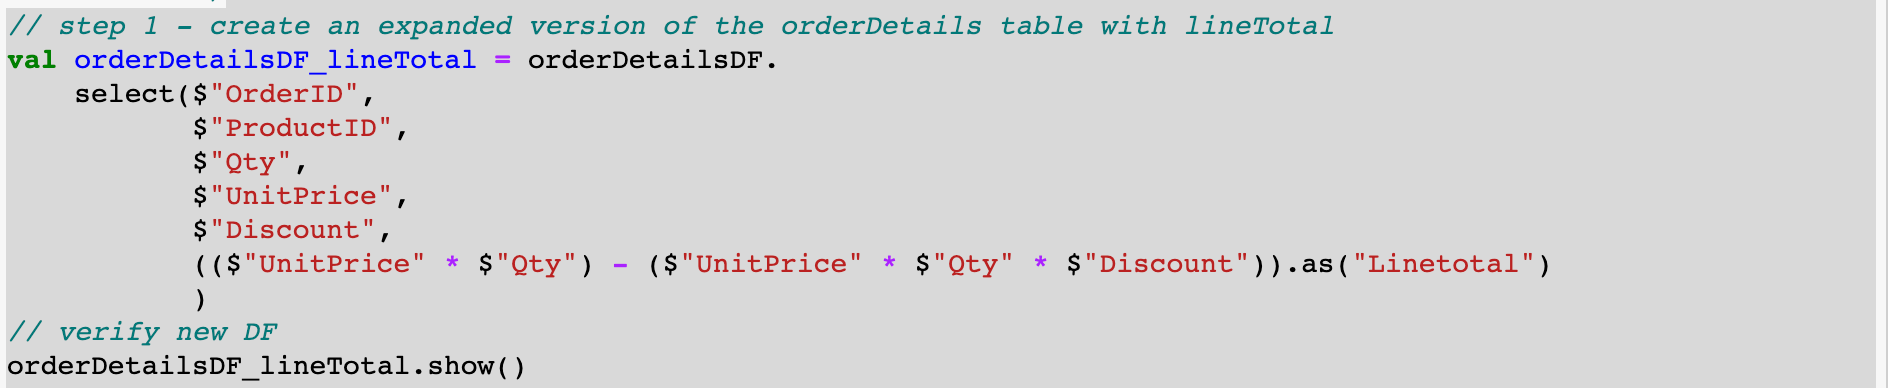

In [14]:
val orderDetailsDF_lineTotal = orderDetailsDF.
    select($"OrderID",
           $"ProductID",
           $"QTY",
           $"UnitPrice",
           $"Discount",
           (($"UnitPrice" * $"Qty") - ($"UnitPrice" * $"Qty" * $"Discount")).as("Linetotal")
          )

orderDetailsDF_lineTotal.show()

+-------+---------+---+---------+--------+------------------+
|OrderID|ProductID|QTY|UnitPrice|Discount|         Linetotal|
+-------+---------+---+---------+--------+------------------+
|  10248|       11| 12|     14.0|     0.0|             168.0|
|  10248|       42| 10|      9.8|     0.0|              98.0|
|  10248|       72|  5|     34.8|     0.0|             174.0|
|  10249|       14|  9|     18.6|     0.0|             167.4|
|  10249|       51| 40|     42.4|     0.0|            1696.0|
|  10250|       41| 10|      7.7|     0.0|              77.0|
|  10250|       51| 35|     42.4|    0.15|            1261.4|
|  10250|       65| 15|     16.8|    0.15|             214.2|
|  10251|       22|  6|     16.8|    0.05|             95.76|
|  10251|       57| 15|     15.6|    0.05|             222.3|
|  10251|       65| 20|     16.8|     0.0|             336.0|
|  10252|       20| 40|     64.8|    0.05|            2462.4|
|  10252|       33| 25|      2.0|    0.05|              47.5|
|  10252

orderDetailsDF_lineTotal = [OrderID: int, ProductID: int ... 4 more fields]


lastException: Throwable = null


[OrderID: int, ProductID: int ... 4 more fields]

#### Q4 - Step 2
Next, we need to sum the rows belonging to each separate order to create a new dataframe containing a row and total for each order.
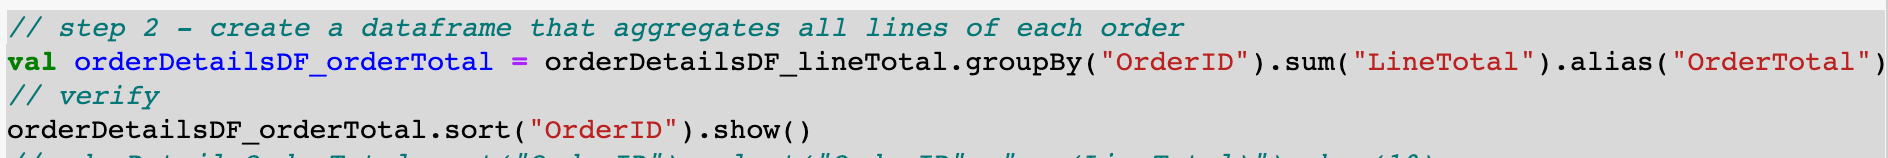

In [15]:
val orderDetailsDF_orderTotal = orderDetailsDF_lineTotal.groupBy("OrderID").sum("LineTotal").alias("OrderTotal")

orderDetailsDF_orderTotal.sort("OrderID").show()

[Stage 38:=================================================>    (184 + 6) / 200]+-------+------------------+
|OrderID|    sum(LineTotal)|
+-------+------------------+
|  10248|             440.0|
|  10249|            1863.4|
|  10250|1552.6000000000001|
|  10251|            654.06|
|  10252|            3597.9|
|  10253|1444.8000000000002|
|  10254| 556.6199999999999|
|  10255|            2490.5|
|  10256|             517.8|
|  10257|            1119.9|
|  10258|           1614.88|
|  10259|             100.8|
|  10260|           1504.65|
|  10261|             448.0|
|  10262|             584.0|
|  10263|            1873.8|
|  10264|           695.625|
|  10265|            1176.0|
|  10266|346.55999999999995|
|  10267|            3536.6|
+-------+------------------+
only showing top 20 rows



orderDetailsDF_orderTotal = [OrderID: int, sum(LineTotal): double]


[OrderID: int, sum(LineTotal): double]

#### Q4 - Step 3
Next, we need to join the OrderDetails datafame with the Orders dataframe to include the CustomerID belonging to each order.
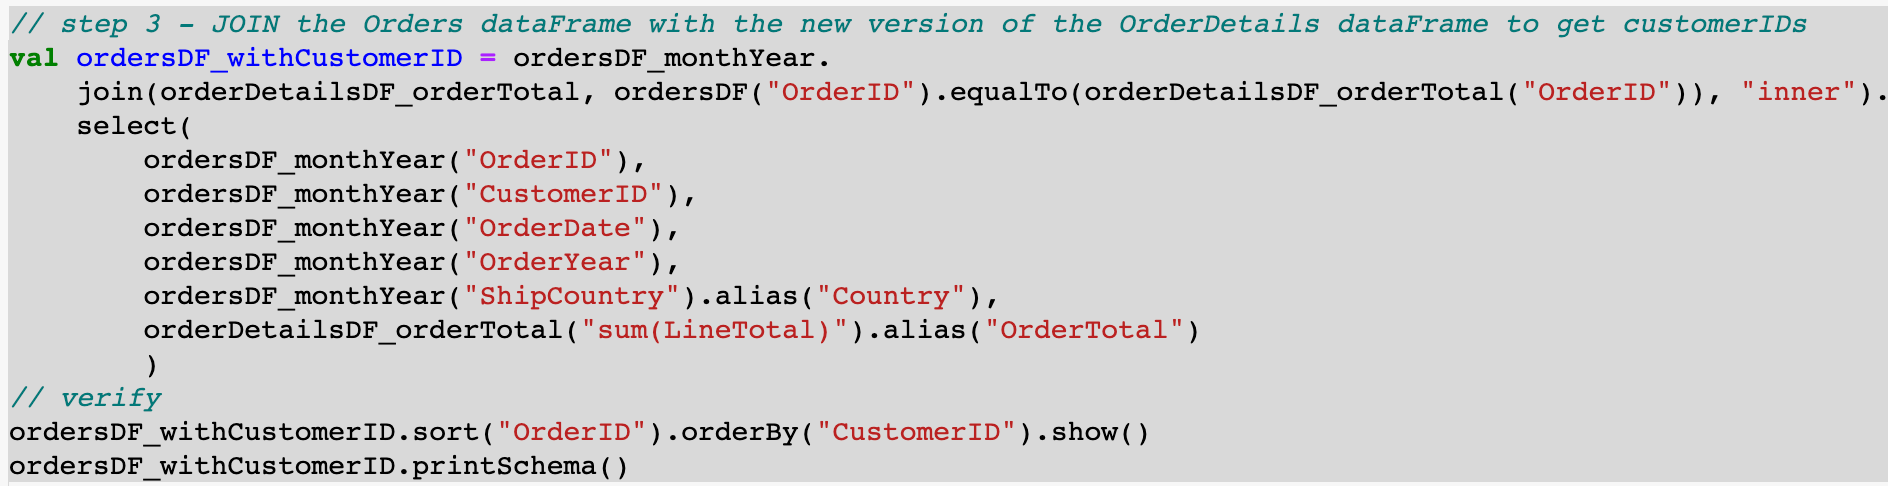

In [17]:
val ordersDF_withCustomerID = ordersDF_monthYear.
    join(orderDetailsDF_orderTotal, ordersDF("OrderID").equalTo(orderDetailsDF_orderTotal("OrderID")), "inner").
    select(
        ordersDF_monthYear("OrderID"),
        ordersDF_monthYear("CustomerID"),
        ordersDF_monthYear("OrderDate"),
        ordersDF_monthYear("OrderYear"),
        ordersDF_monthYear("ShipCountry").alias("Country"),
        orderDetailsDF_orderTotal("sum(LineTotal)").alias("OrderTotal")
        )

ordersDF_withCustomerID.sort("OrderID").orderBy("CustomerID").show()
ordersDF_withCustomerID.printSchema()

+-------+----------+--------------------+---------+-------+------------------+
|OrderID|CustomerID|           OrderDate|OrderYear|Country|        OrderTotal|
+-------+----------+--------------------+---------+-------+------------------+
|  10643|     ALFKI|1997-08-23 00:00:...|     1997|Germany|             814.5|
|  10702|     ALFKI|1997-10-11 00:00:...|     1997|Germany|             330.0|
|  10952|     ALFKI|1998-03-14 00:00:...|     1998|Germany|             471.2|
|  10692|     ALFKI|1997-10-01 00:00:...|     1997|Germany|             878.0|
|  10835|     ALFKI|1998-01-13 00:00:...|     1998|Germany|             845.8|
|  11011|     ALFKI|1998-04-07 00:00:...|     1998|Germany|             933.5|
|  10926|     ANATR|1998-03-02 00:00:...|     1998| Mexico|             514.4|
|  10759|     ANATR|1997-11-26 00:00:...|     1997| Mexico|             320.0|
|  10625|     ANATR|1997-08-06 00:00:...|     1997| Mexico|            479.75|
|  10308|     ANATR|1996-09-16 00:00:...|     1996| 

ordersDF_withCustomerID = [OrderID: int, CustomerID: string ... 4 more fields]


[OrderID: int, CustomerID: string ... 4 more fields]

#### Q4 - Step 4
Finally, we need to ouptut the total sales fore each customer for each year. You should be able to do this part on your own.

Enter code for Q4 below:

In [18]:
// Q4 - What is the total sales by customer by year?

val totalSalesByCustomerByYear = ordersDF_withCustomerID
  .groupBy("CustomerID", "OrderYear")
  .sum("OrderTotal")
  .withColumnRenamed("sum(OrderTotal)", "TotalSales")
  .orderBy("CustomerID", "OrderYear")

totalSalesByCustomerByYear.show()


[Stage 47:==========================================>           (159 + 6) / 200]+----------+---------+------------------+
|CustomerID|OrderYear|        TotalSales|
+----------+---------+------------------+
|     ALFKI|     1997|            2022.5|
|     ALFKI|     1998|            2250.5|
|     ANATR|     1996|              88.8|
|     ANATR|     1997|            799.75|
|     ANATR|     1998|             514.4|
|     ANTON|     1996|403.20000000000005|
|     ANTON|     1997|         5960.7775|
|     ANTON|     1998|             660.0|
|     AROUT|     1996|            1379.0|
|     AROUT|     1997| 6406.900000000001|
|     AROUT|     1998|           5604.75|
|     BERGS|     1996|            4324.4|
|     BERGS|     1997|         13849.015|
|     BERGS|     1998|         6754.1625|
|     BLAUS|     1997|            1079.8|
|     BLAUS|     1998|            2160.0|
|     BLONP|     1996|            9986.2|
|     BLONP|     1997|           7817.88|
|     BLONP|     1998|             730

totalSalesByCustomerByYear = [CustomerID: string, OrderYear: int ... 1 more field]


[CustomerID: string, OrderYear: int ... 1 more field]

---
### Q5. What is the average order total by customer? by customer and year?

In [19]:
// Q5.1 Average Order Total by Customer
val avgOrderTotalByCustomer = ordersDF_withCustomerID
  .groupBy("CustomerID")
  .avg("OrderTotal")
  .withColumnRenamed("avg(OrderTotal)", "AverageOrderTotal")
  .orderBy("CustomerID")

avgOrderTotalByCustomer.show()


+----------+------------------+
|CustomerID| AverageOrderTotal|
+----------+------------------+
|     ALFKI| 712.1666666666666|
|     ANATR|350.73749999999995|
|     ANTON|1003.4253571428571|
|     AROUT|1030.0500000000002|
|     BERGS|1384.8654166666668|
|     BLAUS| 462.8285714285715|
|     BLONP|1684.9163636363637|
|     BOLID|           1410.95|
|     BONAP|1291.9560294117648|
|     BOTTM|1485.8285714285714|
|     BSBEV|            608.99|
|     CACTU|302.46666666666664|
|     CENTC|             100.8|
|     CHOPS|           1543.61|
|     COMMI|            762.15|
|     CONSH| 573.0333333333333|
|     DRACD| 627.2016666666667|
|     DUMON|           403.975|
|     EASTC|       1845.129375|
|     ERNSH|3495.8326166666666|
+----------+------------------+
only showing top 20 rows



avgOrderTotalByCustomer = [CustomerID: string, AverageOrderTotal: double]


[CustomerID: string, AverageOrderTotal: double]

In [20]:
// Q5.2 Average Order Total by Customer and Year
val avgOrderTotalByCustomerYear = ordersDF_withCustomerID
  .groupBy("CustomerID", "OrderYear")
  .avg("OrderTotal")
  .withColumnRenamed("avg(OrderTotal)", "AverageOrderTotal")
  .orderBy("CustomerID", "OrderYear")

avgOrderTotalByCustomerYear.show()


+----------+---------+------------------+
|CustomerID|OrderYear| AverageOrderTotal|
+----------+---------+------------------+
|     ALFKI|     1997| 674.1666666666666|
|     ALFKI|     1998| 750.1666666666666|
|     ANATR|     1996|              88.8|
|     ANATR|     1997|           399.875|
|     ANATR|     1998|             514.4|
|     ANTON|     1996|403.20000000000005|
|     ANTON|     1997|         1192.1555|
|     ANTON|     1998|             660.0|
|     AROUT|     1996|             689.5|
|     AROUT|     1997| 915.2714285714286|
|     AROUT|     1998|         1401.1875|
|     BERGS|     1996|1441.4666666666665|
|     BERGS|     1997|         1384.9015|
|     BERGS|     1998|         1350.8325|
|     BLAUS|     1997|            269.95|
|     BLAUS|     1998|             720.0|
|     BLONP|     1996|3328.7333333333336|
|     BLONP|     1997|           1116.84|
|     BLONP|     1998|             730.0|
|     BOLID|     1996|             982.0|
+----------+---------+------------

avgOrderTotalByCustomerYear = [CustomerID: string, OrderYear: int ... 1 more field]


[CustomerID: string, OrderYear: int ... 1 more field]

---
# Advanced Queries

---
### Q6. Most frequently ordered Products (15 pts)

Show the customerID and their most frequently ordered productID. (i.e., the product they ordered the most times, not necessarily in the greatest quantity.) The final output should be the CustomerID for each customer and the number of times they ordered their most frequently ordered product.
   - Hint: Consider CustomerID SAVEA. They ordered productID 2, five different times. This was the product they ordered most frequently, not necessarily in the highest quantity, but the product that appeared most often on their orders.
 

In [34]:
import org.apache.spark.sql.functions._



In [35]:
// Join ordersDF with orderDetailsDF on OrderID to correlate CustomerIDs with ProductIDs
val customerProductJoin = ordersDF.join(orderDetailsDF, ordersDF("OrderID") === orderDetailsDF("OrderID"))
  .select(ordersDF("CustomerID"), orderDetailsDF("ProductID"))

// Count how often each product was ordered by each customer
val productFrequencyByCustomer = customerProductJoin.groupBy("CustomerID", "ProductID").count()

// Find the maximum frequency of ordered products for each customer
val maxFrequencyByCustomer = productFrequencyByCustomer.groupBy("CustomerID")
  .agg(max("count").alias("MaxFrequency"))

// Join the max frequency back to the original frequency count to get the product(s)
val mostFrequentlyOrderedProducts = productFrequencyByCustomer.join(maxFrequencyByCustomer, 
  productFrequencyByCustomer("CustomerID") === maxFrequencyByCustomer("CustomerID") 
  && productFrequencyByCustomer("count") === maxFrequencyByCustomer("MaxFrequency"))
  .select(productFrequencyByCustomer("CustomerID"), productFrequencyByCustomer("ProductID"), productFrequencyByCustomer("count"))

// Show the result
mostFrequentlyOrderedProducts.show()


[Stage 126:=============================================>       (171 + 6) / 200]+----------+---------+-----+
|CustomerID|ProductID|count|
+----------+---------+-----+
|     ROMEY|       30|    3|
|     VINET|       72|    2|
|     BOTTM|       62|    3|
|     BSBEV|       13|    2|
|     BSBEV|        7|    2|
|     BSBEV|       21|    2|
|     LAUGB|       77|    1|
|     LAUGB|       23|    1|
|     LAUGB|       70|    1|
|     LAUGB|       25|    1|
|     LAUGB|       41|    1|
|     LAUGB|       52|    1|
|     LAUGB|       24|    1|
|     LAUGB|       13|    1|
|     PERIC|       52|    1|
|     PERIC|        1|    1|
|     PERIC|       24|    1|
|     PERIC|       51|    1|
|     PERIC|       14|    1|
|     PERIC|       11|    1|
+----------+---------+-----+
only showing top 20 rows



customerProductJoin = [CustomerID: string, ProductID: int]
productFrequencyByCustomer = [CustomerID: string, ProductID: int ... 1 more field]
maxFrequencyByCustomer = [CustomerID: string, MaxFrequency: bigint]
mostFrequentlyOrderedProducts = [CustomerID: string, ProductID: int ... 1 more field]


[CustomerID: string, ProductID: int ... 1 more field]

In [36]:
customerProductJoin.filter($"CustomerID" === "SAVEA")
  .groupBy("CustomerID", "ProductID")
  .count()
  .orderBy($"count".desc)
  .show()


+----------+---------+-----+
|CustomerID|ProductID|count|
+----------+---------+-----+
|     SAVEA|        2|    5|
|     SAVEA|       13|    4|
|     SAVEA|       41|    4|
|     SAVEA|       56|    4|
|     SAVEA|       68|    4|
|     SAVEA|       17|    3|
|     SAVEA|       16|    3|
|     SAVEA|       29|    3|
|     SAVEA|       19|    3|
|     SAVEA|       55|    3|
|     SAVEA|       33|    3|
|     SAVEA|       60|    3|
|     SAVEA|       24|    3|
|     SAVEA|       49|    3|
|     SAVEA|       71|    3|
|     SAVEA|       62|    3|
|     SAVEA|       35|    3|
|     SAVEA|        1|    3|
|     SAVEA|       31|    3|
|     SAVEA|       75|    3|
+----------+---------+-----+
only showing top 20 rows



---
### Q7 - Bottom 3 Customers (15 pts)
Find the bottom 3 customers who placed the fewest number of orders. For these customers, output the companyName, contactName, and contactTitle.

In [37]:


// Join ordersDF with customersDF on CustomerID to correlate orders with customer details
val ordersCustomersJoin = ordersDF.join(customersDF, ordersDF("CustomerID") === customersDF("CustomerID"))
  .select(customersDF("CustomerID"), col("CompanyName"), col("ContactName"), col("ContactTitle"))

// Count the number of orders per customer
val ordersCountPerCustomer = ordersCustomersJoin.groupBy("CustomerID", "CompanyName", "ContactName", "ContactTitle").agg(count("CustomerID").alias("OrderCount"))

// Find the bottom 3 customers with the fewest number of orders
val bottom3Customers = ordersCountPerCustomer.orderBy(col("OrderCount").asc).limit(3)

// Show the result
bottom3Customers.show()



+----------+--------------------+---------------+-----------------+----------+
|CustomerID|         CompanyName|    ContactName|     ContactTitle|OrderCount|
+----------+--------------------+---------------+-----------------+----------+
|     CENTC|Centro comercial ...|Francisco Chang|Marketing Manager|         1|
|     LAZYK|Lazy K Kountry Store|     John Steel|Marketing Manager|         2|
|     GROSR|GROSELLA-Restaurante| Manuel Pereira|            Owner|         2|
+----------+--------------------+---------------+-----------------+----------+



ordersCustomersJoin = [CustomerID: string, CompanyName: string ... 2 more fields]
ordersCountPerCustomer = [CustomerID: string, CompanyName: string ... 3 more fields]
bottom3Customers = [CustomerID: string, CompanyName: string ... 3 more fields]


[CustomerID: string, CompanyName: string ... 3 more fields]

---
# Open-Ended Analysis

---
### Q8 - Discount Pattern? (20 pts)

If you look in the OrderDetails table, around 38% of all orders received some sort of discount. Can you detect any patterns of why some orders got a discount, while others received 0 discount? 

Please provide your analysis process and a summary of what you find.

In [38]:
//Calculate Discount Rates

val discountSummary = orderDetailsDF
  .withColumn("HasDiscount", when($"Discount" > 0, "With Discount").otherwise("No Discount"))
  .groupBy("HasDiscount")
  .count()

discountSummary.show()




+-------------+-----+
|  HasDiscount|count|
+-------------+-----+
|  No Discount| 1317|
|With Discount|  838|
+-------------+-----+



discountSummary = [HasDiscount: string, count: bigint]


[HasDiscount: string, count: bigint]

In [39]:
//Analyze Discount by Quantity Ordered

val discountByQuantity = orderDetailsDF
  .groupBy("Qty")
  .agg(avg("Discount").alias("AverageDiscount"))
  .orderBy($"Qty".desc)

discountByQuantity.show()


+---+-------------------+
|Qty|    AverageDiscount|
+---+-------------------+
|130|               0.05|
|120|            0.06875|
|110|                0.0|
|100|0.10500000000000001|
| 91|                0.0|
| 90|0.09999999999999999|
| 84|               0.15|
| 80|            0.08125|
| 77|0.05000000000000001|
| 70|0.08392857142857144|
| 66|               0.15|
| 65|                0.1|
| 63|                0.0|
| 60|0.06896551724137931|
| 56|0.08333333333333333|
| 55|0.06666666666666667|
| 54|                0.1|
| 52|                0.0|
| 50|0.06933333333333333|
| 49| 0.1142857142857143|
+---+-------------------+
only showing top 20 rows



discountByQuantity = [Qty: int, AverageDiscount: double]


[Qty: int, AverageDiscount: double]

In [40]:
//Analyze Discount by Product

val discountByProduct = orderDetailsDF
  .groupBy("ProductID")
  .agg(avg("Discount").alias("AverageDiscount"))
  .orderBy($"AverageDiscount".desc)

discountByProduct.show()


+---------+-------------------+                                                 
|ProductID|    AverageDiscount|
+---------+-------------------+
|       48|0.10833333333333334|
|        2|0.10227272727272729|
|        9|                0.1|
|       58|                0.1|
|       25|0.08611111111111111|
|       30|0.08124999999999999|
|       18|0.07962962962962962|
|       36|0.07903225806451612|
|        1|0.07763157894736841|
|       55|0.07727272727272728|
|       45|0.07500000000000002|
|        4|              0.075|
|        5|              0.075|
|       69|0.07419354838709677|
|       47|0.07380952380952381|
|       32|0.07333333333333333|
|       54|0.07222222222222223|
|       61|0.07083333333333332|
|       14|0.06727272727272728|
|       16| 0.0669767441860465|
+---------+-------------------+
only showing top 20 rows



discountByProduct = [ProductID: int, AverageDiscount: double]


[ProductID: int, AverageDiscount: double]

In [42]:
//Analyze Discount by Unit Price

val discountByUnitPrice = orderDetailsDF
  .groupBy("UnitPrice")
  .agg(avg("Discount").alias("AverageDiscount"))
  .orderBy($"UnitPrice".desc)

discountByUnitPrice.show()


+---------+--------------------+
|UnitPrice|     AverageDiscount|
+---------+--------------------+
|    263.5|            0.021875|
|    210.8|             0.09375|
|   123.79| 0.07727272727272727|
|     99.0|0.034999999999999996|
|     97.0|                 0.1|
|     81.0|                0.04|
|     77.6|                 0.1|
|     64.8|                0.06|
|     62.5| 0.08571428571428572|
|     55.0| 0.04000000000000001|
|     53.0| 0.04666666666666667|
|     50.0| 0.05833333333333334|
|     49.3|  0.0661764705882353|
|     46.0| 0.07105263157894737|
|     45.6|0.045000000000000005|
|     44.0| 0.06052631578947368|
|     43.9|0.011764705882352941|
|     42.4| 0.06666666666666667|
|     40.0| 0.05454545454545454|
|     39.4|0.024999999999999998|
+---------+--------------------+
only showing top 20 rows



discountByUnitPrice = [UnitPrice: double, AverageDiscount: double]


[UnitPrice: double, AverageDiscount: double]

In [44]:
//Aggregate Discount Information by Customer

// Join order details with orders to get CustomerID for each order detail
val customerDiscounts = orderDetailsDF
  .join(ordersDF, orderDetailsDF("OrderID") === ordersDF("OrderID"))
  .groupBy(ordersDF("CustomerID"))
  .agg(
    avg("Discount").alias("AverageDiscount"),
    countDistinct(orderDetailsDF("OrderID")).alias("TotalOrders")
  )
  .orderBy($"AverageDiscount".desc)

customerDiscounts.show()


[Stage 163:=============================================>       (170 + 6) / 200]+----------+-------------------+-----------+
|CustomerID|    AverageDiscount|TotalOrders|
+----------+-------------------+-----------+
|     SIMOB|               0.14|          7|
|     LAMAI|0.12580645161290324|         14|
|     BOLID|0.11666666666666665|          3|
|     HUNGO|0.11363636363636363|         19|
|     LETSS|0.11000000000000001|          4|
|     FURIB|             0.0975|          8|
|     LILAS|0.09705882352941175|         14|
|     LEHMS|0.09615384615384616|         15|
|     SPLIR|             0.0925|          9|
|     VICTE|              0.092|         10|
|     PRINI|               0.09|          5|
|     QUEEN|               0.09|         13|
|     TOMSP|0.08928571428571429|          6|
|     LINOD|0.08857142857142856|         12|
|     WANDK|0.08846153846153845|         10|
|     ALFKI|0.08750000000000001|          6|
|     FOLKO|0.08555555555555557|         19|
|     BOTTM| 0.08428

customerDiscounts = [CustomerID: string, AverageDiscount: double ... 1 more field]


[CustomerID: string, AverageDiscount: double ... 1 more field]

In [47]:
//Join with Customer Details



val customerDetailsWithDiscounts = customerDiscounts
  .join(customersDF, customerDiscounts("CustomerID") === customersDF("CustomerID"))
  .select(
    customersDF("CustomerID"), 
    col("CompanyName"), 
    col("ContactName"), 
    col("ContactTitle"), 
    col("AverageDiscount"), 
    col("TotalOrders")
  )
  .orderBy(col("AverageDiscount").desc)

customerDetailsWithDiscounts.show()



[Stage 168:=============================================>       (170 + 6) / 200]+----------+--------------------+------------------+--------------------+-------------------+-----------+
|CustomerID|         CompanyName|       ContactName|        ContactTitle|    AverageDiscount|TotalOrders|
+----------+--------------------+------------------+--------------------+-------------------+-----------+
|     SIMOB|       Simons bistro|    Jytte Petersen|               Owner|               0.14|          7|
|     LAMAI|    La maison d'Asie|    Annette Roulet|       Sales Manager|0.12580645161290324|         14|
|     BOLID|Bólido Comidas pr...|     Martín Sommer|               Owner|0.11666666666666665|          3|
|     HUNGO|Hungry Owl All-Ni...|  Patricia McKenna|     Sales Associate|0.11363636363636363|         19|
|     LETSS|   Let's Stop N Shop|      Jaime Yorres|               Owner|0.11000000000000001|          4|
|     FURIB|Furia Bacalhau e ...|    Lino Rodriguez|       Sales Manager

customerDetailsWithDiscounts = [CustomerID: string, CompanyName: string ... 4 more fields]


[CustomerID: string, CompanyName: string ... 4 more fields]

In [48]:
val productDiscountAnalysisExtended = orderDetailsDF
  .groupBy("ProductID")
  .agg(
    avg("Discount").alias("AverageDiscount"),
    max("Discount").alias("MaxDiscount"),
    min("Discount").alias("MinDiscount"),
    avg("UnitPrice").alias("AverageUnitPrice"),
    sum("Qty").alias("TotalQuantityOrdered"),
    count("OrderID").alias("TotalOrders")
  )
  .orderBy($"AverageDiscount".desc)

productDiscountAnalysisExtended.show()


+---------+-------------------+-----------+-----------+------------------+--------------------+-----------+
|ProductID|    AverageDiscount|MaxDiscount|MinDiscount|  AverageUnitPrice|TotalQuantityOrdered|TotalOrders|
+---------+-------------------+-----------+-----------+------------------+--------------------+-----------+
|       48|0.10833333333333334|       0.15|        0.0|              11.9|                 138|          6|
|        2|0.10227272727272729|       0.25|        0.0|17.877272727272725|                1057|         44|
|       58|                0.1|       0.25|        0.0|12.661111111111111|                 534|         18|
|        9|                0.1|       0.25|        0.0|             93.12|                  95|          5|
|       25|0.08611111111111111|       0.25|        0.0|13.066666666666666|                 318|         18|
|       30|0.08124999999999999|       0.25|        0.0| 24.26812499999999|                 612|         32|
|       18|0.079629629629629

productDiscountAnalysisExtended = [ProductID: int, AverageDiscount: double ... 5 more fields]


[ProductID: int, AverageDiscount: double ... 5 more fields]

In [52]:
//Seasonality of Discounts

val ordersWithDate = ordersDF
  .withColumn("OrderMonth", month($"OrderDate"))
  .withColumn("OrderYear", year($"OrderDate"))

val seasonalDiscountAnalysis = ordersWithDate
  .join(orderDetailsDF, "OrderID")
  .groupBy("OrderMonth", "OrderYear", "ProductID")
  .agg(avg("Discount").alias("AverageDiscount"))
  .orderBy($"OrderYear", $"OrderMonth", $"AverageDiscount".desc)

seasonalDiscountAnalysis.show(1000)


+----------+---------+---------+--------------------+
|OrderMonth|OrderYear|ProductID|     AverageDiscount|
+----------+---------+---------+--------------------+
|         7|     1996|       62|                0.25|
|         7|     1996|       30|                0.25|
|         7|     1996|       32|                 0.2|
|         7|     1996|        5|                 0.2|
|         7|     1996|       55|                0.15|
|         7|     1996|       76|                0.15|
|         7|     1996|       41| 0.13333333333333333|
|         7|     1996|       74|               0.125|
|         7|     1996|       70|               0.125|
|         7|     1996|       16|               0.125|
|         7|     1996|       51|               0.075|
|         7|     1996|       59|               0.075|
|         7|     1996|       65|               0.075|
|         7|     1996|       24|               0.075|
|         7|     1996|        2| 0.06666666666666667|
|         7|     1996|      

ordersWithDate = [OrderID: int, CustomerID: string ... 5 more fields]
seasonalDiscountAnalysis = [OrderMonth: int, OrderYear: int ... 2 more fields]


[OrderMonth: int, OrderYear: int ... 2 more fields]

In [55]:
//Discount Impact on Sales Volume

val discountSalesVolume = orderDetailsDF
  .groupBy("ProductID", "Discount")
  .agg(sum("Qty").alias("TotalQuantitySold"))
  .orderBy($"Discount".desc, $"TotalQuantitySold".desc)

discountSalesVolume.show(100)


+---------+--------+-----------------+
|ProductID|Discount|TotalQuantitySold|
+---------+--------+-----------------+
|        2|    0.25|              207|
|       29|    0.25|              202|
|       60|    0.25|              199|
|       17|    0.25|              167|
|       30|    0.25|              162|
|       47|    0.25|              150|
|       16|    0.25|              140|
|        1|    0.25|              139|
|       68|    0.25|              137|
|       36|    0.25|              135|
|       59|    0.25|              130|
|       55|    0.25|              130|
|       61|    0.25|              120|
|       54|    0.25|              119|
|       24|    0.25|              116|
|       69|    0.25|              110|
|       26|    0.25|              105|
|       56|    0.25|               86|
|       62|    0.25|               86|
|       51|    0.25|               78|
|       11|    0.25|               75|
|        8|    0.25|               70|
|       77|    0.25|     

discountSalesVolume = [ProductID: int, Discount: double ... 1 more field]


[ProductID: int, Discount: double ... 1 more field]

In [63]:
//Aggregate Data for Product Discounts and Customer Orders

val productDiscountSummary = ordersWithDetails
  .groupBy("ProductID")
  .agg(
    avg("Discount").alias("AverageDiscount"),
    countDistinct("CustomerID").alias("TotalUniqueCustomers"),
    count("OrderID").alias("TotalOrders"),
    sum("Qty").alias("TotalQuantityOrdered")
  )
  .orderBy($"AverageDiscount".desc)

productDiscountSummary.show()



[Stage 204:===================================================> (195 + 5) / 200]+---------+-------------------+--------------------+-----------+--------------------+
|ProductID|    AverageDiscount|TotalUniqueCustomers|TotalOrders|TotalQuantityOrdered|
+---------+-------------------+--------------------+-----------+--------------------+
|       48|0.10833333333333334|                   6|          6|                 138|
|        2|0.10227272727272728|                  28|         44|                1057|
|        9|                0.1|                   5|          5|                  95|
|       58|0.09999999999999999|                  17|         18|                 534|
|       25|0.08611111111111112|                  16|         18|                 318|
|       30|            0.08125|                  22|         32|                 612|
|       18|0.07962962962962962|                  22|         27|                 539|
|       36|0.07903225806451614|                  23|        

productDiscountSummary = [ProductID: int, AverageDiscount: double ... 3 more fields]


[ProductID: int, AverageDiscount: double ... 3 more fields]

# Analysis Process and Summary:

### In my analysis, I explored various dimensions of discounts, including rates, quantities ordered, product-specific, unit price, customer-specific, seasonality, and total sales volume. The findings reveal a strong correlation between product ID and average discount rate, as well as between customer ID and average discount rate. However, no significant patterns emerged with discounts by quantity ordered, unit price, seasonality, or total sales volume.

### To determine the predictive power of discount rates, further regression analysis is necessary. Additionally, identifying predictive variables with causality would require the application of causal inference techniques, such as controlling for confounding factors, to pinpoint the origins of the discounts.


